In [ ]:
#Q4. IMDB dataset
#영화 리뷰 코멘트의 긍정/부정 감성 판단을 위해 사용하는 Sentiment analysis dataset
#Train : 25,000 (text, label) / Test : 25,000 (text, label)
#torchtext : 자연어 전처리용 라이브러리
!pip install torchtext==0.15.2
!pip install portalocker
!pip install accelerate -U
#code 실행 후 세션 초기화 진행

In [34]:
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')
test_iter = IMDB(split='test')

In [35]:
import random

random.seed(6) #재현성

train_lists = list(train_iter)
test_lists = list(test_iter)

len(train_lists),len(test_lists)

(25000, 25000)

In [36]:
train_lists_small = random.sample(train_lists,1000)
test_lists_small = random.sample(test_lists,1000)
#긍정 2, 부정 1
print(train_lists_small[0])
print(test_lists_small[0])

(2, "I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.")
(1, 'This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Tru

In [37]:
#Q5. label encoding
train_texts = []
train_labels = []

for label, text in train_lists_small:
    train_labels.append(1 if label==2 else 0) #1 긍정 0 부정 으로 mapping
    train_texts.append(text)

test_texts = []
test_labels = []

for label, text in test_lists_small:
    test_labels.append(1 if label==2 else 0) #1 긍정 0 부정 으로 mapping
    test_texts.append(text)

print(train_texts[0])
print(train_labels[0])

print(test_texts[0])
print(test_labels[0])



I LOVED this movie! I am biased seeing as I am a huge Disney fan, but I really enjoyed myself. The action takes off running in the beginning of the film and just keeps going! This is a bit of a departure for Disney, they don't spend quite as much time on character development (my husband pointed this out)and there are no musical numbers. It is strictly action adventure. I thoroughly enjoyed it and recommend it to anyone who loves Disney, be they young or old.
1
This was an abysmal show. In short it was about this kid called Doug who guilt-tripped a lot. Seriously he could feel guilty over killing a fly then feeling guilty over feeling guilty for killing the fly and so forth. The animation was grating and unpleasant and the jokes cheap. <br /><br />It aired here in Sweden as a part of the "Disney time" show and i remember liking it some what but then i turned 13.<br /><br />I never got why some of the characters were green and purple too. What was up with that? <br /><br />Truly a horri

In [38]:
#Q6. Train / Validation Split
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2, random_state=3)

print(len(train_texts))
print(len(train_labels))
print(len(val_texts))
print(len(val_labels))

800
800
200
200


In [39]:
#Q7. Tokenizing, Encoding
#distilbert-base-uncased 모델에서 tokenizer 불러오기, 사용하는 이유 : 가벼워서 colab에서 사용할 수 있어서 (런타임 끊기지 않기위해..)
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

/home/jycni/anaconda3/envs/light/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [40]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True) #truncation , max_length 넘는 입력 truncation
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

print(train_encodings["input_ids"][0][:5]) #0부터 5번째 input_ids 출력 (random)
print(tokenizer.decode(train_encodings["input_ids"][0][:5])) #결과 decode


[101, 4937, 11350, 2038, 2048]
[CLS] cat soup has two


In [41]:
#Q8. make Class : Dataset
import torch

class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self,encodings, labels):
        self.encodings = encodings
        self.labels = labels

    #어떤 방식으로 encoding이 되는지 확인 해봐야 함.
    def __getitem__(self,idx):
        item = {}
        for key, val in self.encodings.items():
            item[key]=torch.tensor(val[idx])

        item['labels']=torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)

val_dataset = IMDbDataset(val_encodings, val_labels)

test_dataset = IMDbDataset(test_encodings, test_labels)

In [42]:
#dataset check
for i in train_dataset:
    print(i)
    break

#encoding 구조
#input_ids, attention_mask, labels  / 좀 더 자세하게 논문 확인해볼 필요가 있음.
#input_ids : vocab
#attention_mask : 패딩의 위치를 나타냄, max_length까지 , 모자란 경우 <PAD> -> 0 으로 채움, 그 위치를 attention_mask로 나타냄
#labels : 이 데이터셋의 경우 부정 0 , 긍정 1

{'input_ids': tensor([  101,  4937, 11350,  2038,  2048,  1000,  7592, 14433,  1000,  1011,
         2828, 18401,  2015, 28866,  2075,  2006,  1037, 13576,  4440,  2083,
         1996, 25115,  1010,  2073,  2505,  2064,  4148,  1010,  1998,  2515,
         1012,  2023,  2568,  1011,  4440,  4691,  4004,  2460,  3594,  2053,
        13764,  8649,  1010,  4942, 21532,  2773, 22163,  2612,  1012,  2045,
         2003,  2053,  2126,  1997,  7851,  2023, 17183, 14088,  9476,  3272,
         2000,  2425,  2017,  2000,  2156,  2009,  2005,  4426,  1012,  1998,
         2191,  2469,  2053,  2028,  2104,  2184,  2003,  1999,  1996,  2282,
         1012,  4487,  6491,  6633,  5677,  3672,  1998,  2064,  3490, 10264,
         2964,  1998, 18186,  1998,  9576,  2854,  1998,  5573,  2331,  1998,
         2655,  3560, 27770,  2005,  2500,  2024,  2691,  6991,  1012,  7481,
         1012,  3383,  1996,  2087, 13432,  3746,  2003,  2008,  1997,  2019,
        10777,  3605,  1997,  2300,  2008,  1996, 

In [43]:
#pre_train model 불러오기
from transformers import DistilBertForSequenceClassification

#distilbert model load
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [44]:
#Q10. Training Arguments
#Train epochs : 8
#train - mini batch_size : 16
#val - mini batch_size = 64
#optim : Adam

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir = './results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size =64,
    warmup_steps=500, #warmup step : 모델 학습 초기에 lr을 점진적으로 증가 , 스케줄링용 웜업 스텝
    weight_decay=0.01,#가중치를 제한하는 regularization 기법, L2 regularization
    logging_dir='./logs',
    logging_steps=10,
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [45]:
#Q11. model.to(device:cuda)
import torch

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu') # True if ... else False
model = model.to(device)

In [46]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Mon Sep 16 14:33:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti      On | 00000000:19:00.0 Off |                  N/A |
|  0%   27C    P2               56W / 250W|   3262MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [47]:
#Q12. Trainer class -> pre_trained
input_tokens = tokenizer(['I feel fantastic.',"My life is going something wrong.",
                          "I have not figured out what the chosen title has to do with the movie."],truncation=True, padding=True)
#input_tokens 출력해서 확인해보기
print(input_tokens["input_ids"])
print(input_tokens["attention_mask"])

[[101, 1045, 2514, 10392, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 2026, 2166, 2003, 2183, 2242, 3308, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2031, 2025, 6618, 2041, 2054, 1996, 4217, 2516, 2038, 2000, 2079, 2007, 1996, 3185, 1012, 102]]
[[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]


In [48]:
outputs=model(torch.tensor(input_tokens["input_ids"]).to(device))
outputs #각 0, 1에 대한 conf argmax로 classification

SequenceClassifierOutput(loss=None, logits=tensor([[0.0146, 0.1398],
        [0.0458, 0.1579],
        [0.0197, 0.0988]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [49]:
label_dict= {0:'positive',1:'negative'}

for i in torch.argmax(outputs['logits'],axis=1).cpu().numpy():
    print(label_dict[i])

negative
negative
negative


In [50]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = train_dataset,
    eval_dataset = val_dataset
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
/home/jycni/anaconda3/envs/light/lib/python3.9/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
10,0.692000
20,0.688500
30,0.685600
40,0.682500
50,0.674500
60,0.657100
70,0.616200
80,0.532700
90,0.418600
100,0.293500


TrainOutput(global_step=104, training_loss=0.5826254383875773, metrics={'train_runtime': 38.933, 'train_samples_per_second': 164.385, 'train_steps_per_second': 2.671, 'total_flos': 847791351398400.0, 'train_loss': 0.5826254383875773, 'epoch': 8.0})

In [51]:
#fine-tuning result
input_tokens = tokenizer(['I feel fantastic.',"My life is going something wrong.",
                          "I have not figured out what the chosen title has to do with the movie."],truncation=True, padding=True)

outputs=model(torch.tensor(input_tokens["input_ids"]).to(device))

label_dict= {1:'positive',0:'negative'} #위에서 1 긍정, 0 부정

for i in torch.argmax(outputs['logits'],axis=1).cpu().numpy():
    print(label_dict[i])


positive
negative
negative


In [52]:
#Q13. Pre-Trained , Transfer Learning

def test_inference(model, tokenizer):
    input_tokens = tokenizer(['I feel fantastic.',"My life is going something wrong.",
                          "I have not figured out what the chosen title has to do with the movie."],truncation=True, padding=True)

    outputs=model(torch.tensor(input_tokens["input_ids"]).to(device))

    label_dict= {1:'positive',0:'negative'} #위에서 1 긍정, 0 부정

    result=[]
    for i in torch.argmax(outputs['logits'],axis=1).cpu().numpy():
        result.append(label_dict[i])

    return result

In [53]:
#1. Load pre_trained model & Tokenizer
#2. DataLoader
#3. Define Optim
#4. model.train()
#5. Repeat tarin_loop for num_epochs
#6. Optim zero_gard (init_gard)
#7. outputs  = model(input)
#8. Loss
#9. backProp
#10. model.step() , update weights

In [54]:
from torch.utils.data import DataLoader
from transformers import DistilBertForSequenceClassification, AdamW
from transformers import DistilBertTokenizerFast

#1. Load pre_trained model & Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model.to(device) #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(test_inference(model,tokenizer))
#2. DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
#3. Define Optim
optim = AdamW(model.parameters(), lr=5e-5)

for i in train_loader :
    print(i)
    break

/home/jycni/anaconda3/envs/light/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['negative', 'negative', 'negative']
{'input_ids': tensor([[  101,  9679,  5735,  ...,     0,     0,     0],
        [  101,  2054,  2062,  ...,     0,     0,     0],
        [  101,  2023,  2143,  ...,     0,     0,     0],
        ...,
        [  101,  1037,  2200,  ..., 26026,  1006,   102],
        [  101,  1008,  1008,  ..., 11477,  2015,   102],
        [  101,  5408,  1000,  ...,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]]), 'labels': tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0])}


/home/jycni/anaconda3/envs/light/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [55]:
#4. model.train(I)
model.train()

losses = []
num_epochs = 8
#5.Repeat tarin_loop for num_epochs
for epoch in range(num_epochs):
    print(f"epoch:{epoch}")
    #6.Optim zero_gard (init_gard)
    for batch in train_loader:
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device) #위의 train_loader 데이터 구조 참고
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        #7. outputs  = model(input)
        outputs = model(input_ids, attention_mask = attention_mask, labels=labels)
        # print("outputs:",outputs)

        #8. Loss
        loss = outputs[0] #loss and logits
        losses.append(loss)

        #9. BackProp
        loss.backward()
        #10. update
        optim.step()

model.eval()
print(test_inference(model,tokenizer))

epoch:0
epoch:1
epoch:2
epoch:3
epoch:4
epoch:5
epoch:6
epoch:7
['positive', 'negative', 'positive']


In [56]:
print(losses)
type(losses)

[tensor(0.7033, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6891, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7445, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7029, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7557, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6908, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6888, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6813, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6892, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7090, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6714, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6971, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6751, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7117, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.7202, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(0.6647, device='

list

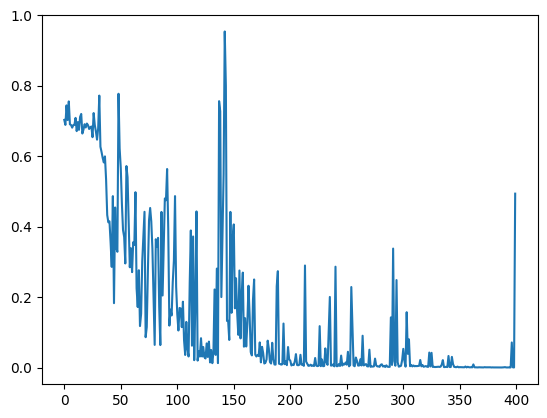

In [57]:
new_losses = [i.item() for i in losses]

import matplotlib.pyplot as plt
plt.plot(new_losses)
plt.show()

In [58]:
#Q14. metric
model.eval()

l=[]

for test_text in test_texts:
    input_tokens = tokenizer(test_text, truncation=True, padding=True)
    
    outputs = model(torch.tensor(input_tokens['input_ids']).unsqueeze(0).to(device))
    
    l.append(torch.argmax(outputs['logits']).item())
correct_cnt = 0

for pred,ans in zip(l,test_labels):
    if pred == ans:
        correct_cnt+=1
print(correct_cnt/len(test_labels))

0.875


In [59]:
#Q15. recall, precision, f1_score
tp=0
tn=0
fp=0
fn=0

for pred,ans in zip(l,test_labels):
    if pred == ans:
        if pred == 1:
            tp+=1
        else:
            tn+=1
    else:
        if pred == 1:
            fp+=1
        else:
            fn+=1
recall = tp/(tp+fn)
precision = tp/(tp+fp)
f1_score = 2*recall*precision/(recall+precision)

print(recall,precision,f1_score)

0.941544885177453 0.822992700729927 0.8782862706913339


In [60]:
#Q16. report
from sklearn.metrics import classification_report
print(classification_report(test_labels,l))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       521
           1       0.82      0.94      0.88       479

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.87      1000
weighted avg       0.88      0.88      0.87      1000

